In [5]:
# %% IMPORTS OF PACKAGES

from os.path import join

import matplotlib.pyplot as plt
import mne
import pandas as pd
import numpy as np

import glob

plt.ion()  # toggle interactive plotting
# import numpy as np

In [6]:
# %% PATHS FOR EXAMPLE ANALYSIS

data_path = "/work/MEG_data"
ID = "0145"
date_stamp = "20240925_000000"
sess = "B"

log_path = join(data_path, 'logfiles')

meg_path = join(data_path, ID, date_stamp, "MEG/001.sessB/files")

subjects_dir = "/work/freesurfer/"
raw_name = "sess" + sess + ".fif"

In [7]:
# %% READ RAW DATA
fname = join(meg_path, raw_name)

In [8]:
raw = mne.io.read_raw_fif(fname, preload=True)

Opening raw data file /work/MEG_data/0145/20240925_000000/MEG/001.sessB/files/sessB.fif...


/tmp/ipykernel_1448/67999550.py:1: RuntimeWarning: This filename (/work/MEG_data/0145/20240925_000000/MEG/001.sessB/files/sessB.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname, preload=True)


FileNotFoundError: fname does not exist: "/work/MEG_data/0145/20240925_000000/MEG/001.sessB/files/sessB.fif"

In [ ]:
# Inspect the raw data
print(raw.info)
raw.plot(start=0, duration=5, n_channels=20)
raw.compute_psd(n_jobs=-1, tmax=9).plot()

NameError: name 'raw' is not defined

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 216 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 306 out of 306 | elapsed:    8.9s finished


Effective window size : 2.048 (s)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  64 | elapsed:    5.3s remaining:    1.8s


Plotting power spectral density (dB=True).


[Parallel(n_jobs=-1)]: Done  61 out of  64 | elapsed:    6.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    6.1s finished


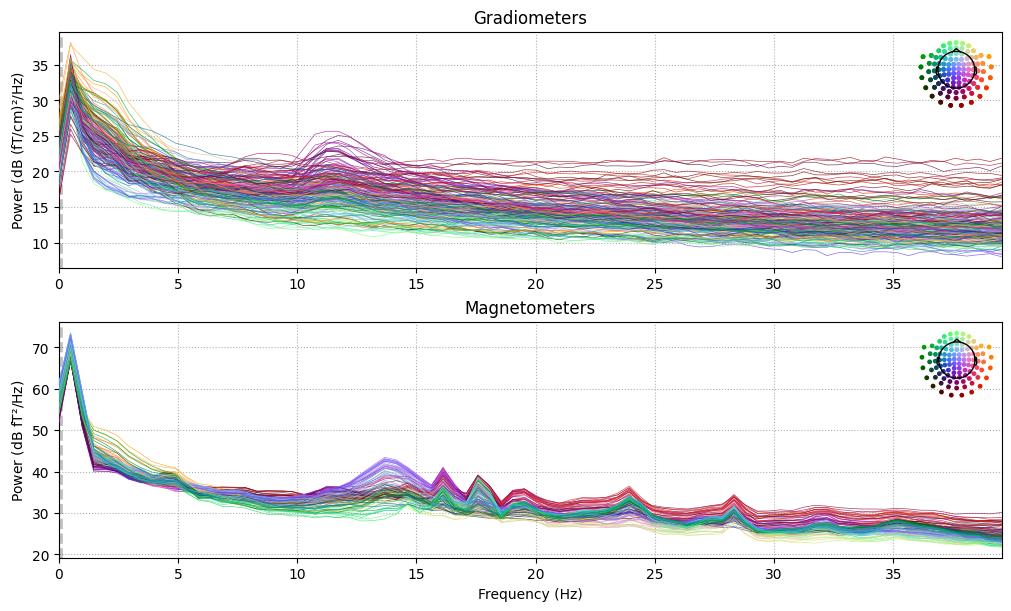

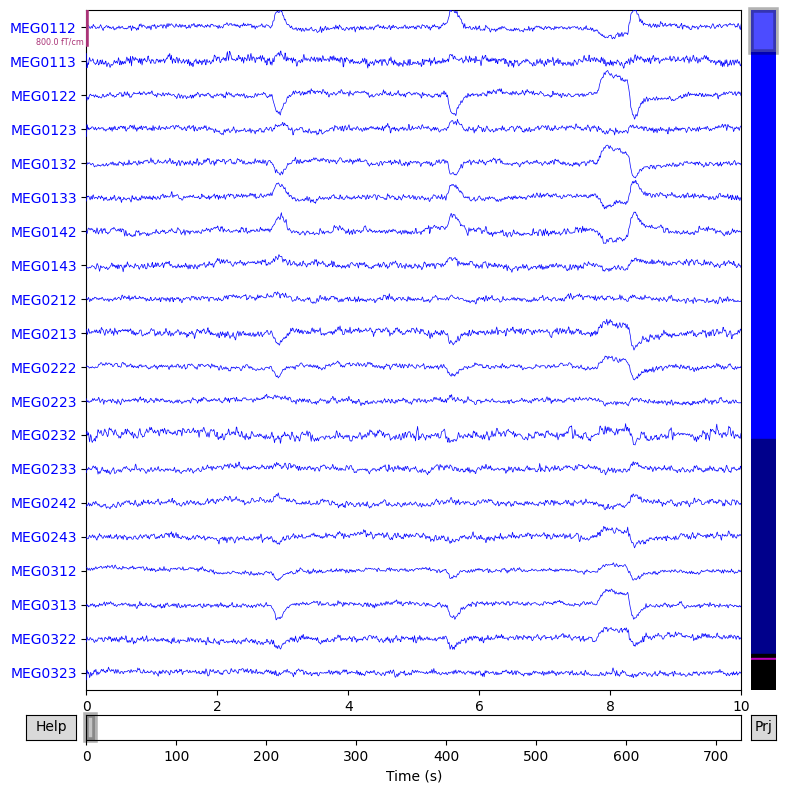

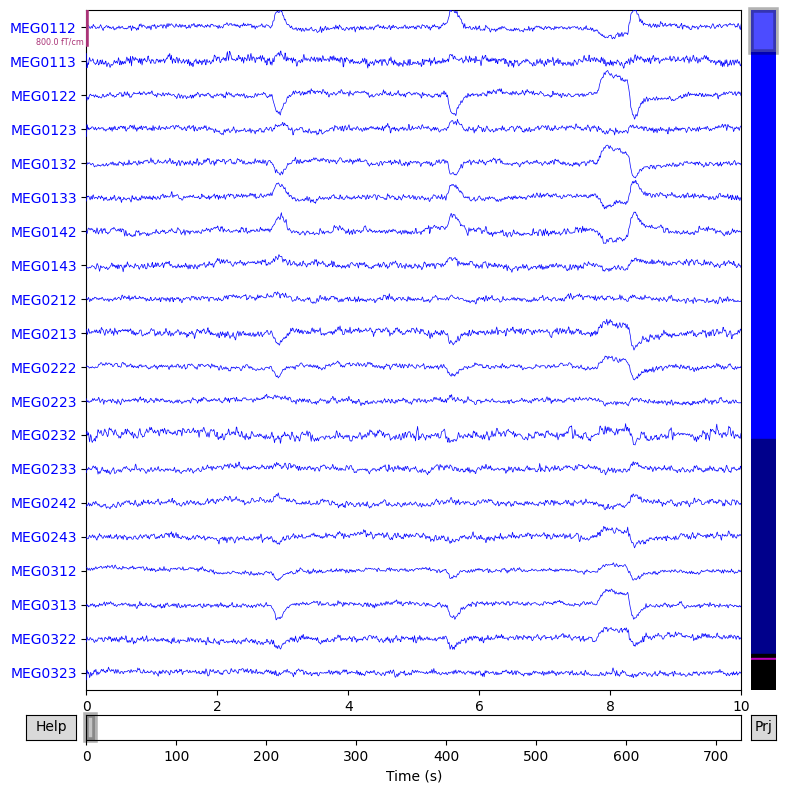

In [ ]:
# Filter the raw data to 40 Hz
raw.filter(l_freq=None, h_freq=40, n_jobs=4)
raw.compute_psd(n_jobs=-1, fmax=40).plot()
raw.plot()

In [ ]:
sfreq = raw.info['sfreq']

In [ ]:
# %% FIND EVENTS

events = mne.find_events(raw, min_duration=0.002, consecutive=True)  ## returns a numpy array

2084 events found on stim channel STI101
Event IDs: [  1   2   3   4  11  12  13  14  15 110 120 126 130 134 140 156 210 211
 220 221 230 231 238 239 240 241 243 246 247 252 254 255]


In [ ]:
# due to the online filtering of the MEG data, the square waves that constitute the trigger values 
# in the STI101-channel are sometimes not read very well during this process - and therefore we'll 
# only focus on those triggers that correspond to trigger values that we know are relevant
trigger_vals = [1,2,3,4,110,120,130,140,210,211,220,221,230,231,240,241]
true_events = events[np.isin(events[:,2], trigger_vals),:]

# unfortunately, the STI101-channel is really acting up in this dataset, and therefore multiple of the 
# relevant triggers are sometimes read as repeated values within a few milliseconds... gotta fix that too
# We identify for which rows the difference between two consecutive trigger values is 0 (i.e. they're identical 
# - cuz that shouldn't ever happen (check the event_id to (maybe) make sense of this)
repeat_idx = np.where(np.diff(true_events[:,2])==0)[0]
repeat_idx2 = repeat_idx+1 # we need the index of both the first and the second value in those pairs (it's only the second of the two that we delete)
repeat_combined = [[i, j] for i, j in zip(repeat_idx, repeat_idx2)] # we group indices in pairs for printing

# print to inspect if needed
#print(cropped_events[repeat_combined, 2])
#print(cropped_events[repeat_combined, :])

cropped_events = np.delete(true_events, repeat_idx2, axis=0)

In [ ]:
# Load confidence data
df = pd.read_csv('../in/merged_df_B.csv') 

In [ ]:
# cleaning the concatenated logfiles a bit

df_cropped = df.drop(['ID', 'dur_measured_decks', 'offset_decks', 'exp_type', 'offset_win'], axis=1) # throwing out columns with all NaN
df_cropped['deck_marked'] = df_cropped['init_mark'] + 1 # adjusting the indexing of "init_mark" to reflect actual deck-number rather than python index

In [ ]:
# quick glance at the deck-screen-labels
df_cropped[['init_mark', 'deck_marked', 'deck_select', 'n_moves','confidence']]

,init_mark,deck_marked,deck_select,n_moves,confidence
0,2,3,2,3,0
1,3,4,1,1,0
2,3,4,4,4,0
3,0,1,2,1,1
4,1,2,2,0,0
...,...,...,...,...,...
155,1,2,4,2,1
156,1,2,4,2,1
157,1,2,4,2,1
158,1,2,4,2,1


/tmp/ipykernel_1093/1106699013.py:29: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events_combined, sfreq=raw.info["sfreq"]);


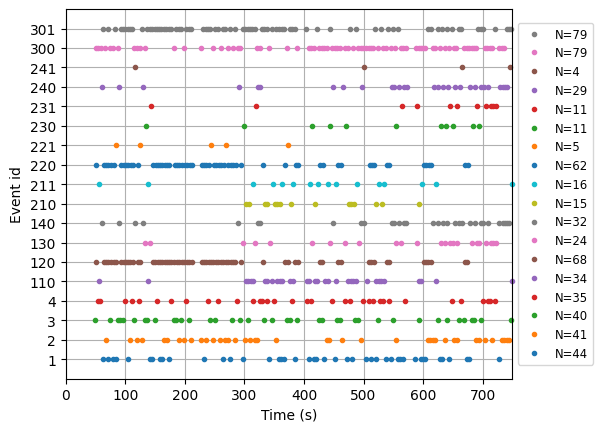

Not setting metadata
158 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 158 events and 701 original time points ...
0 bad epochs dropped


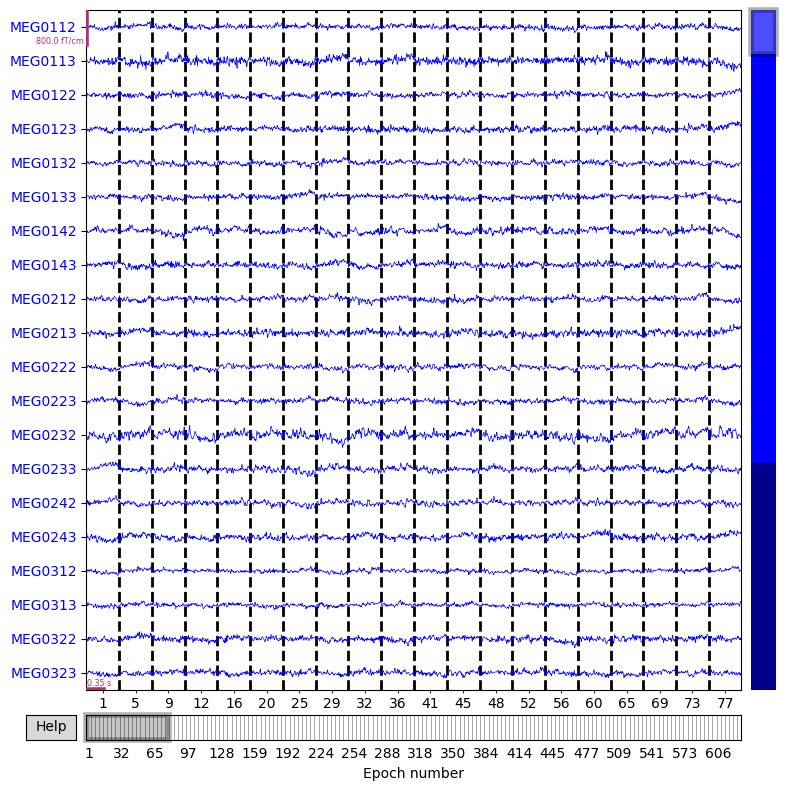

In [ ]:
# Inputting df["confidence"] as a trigger in the events for MNE

# Align confidence events with 'Response/Select' events
select_event_codes = [110, 120, 130, 140]
select_events = cropped_events[np.isin(cropped_events[:, 2], select_event_codes)]

# Ensure alignment by taking the minimum length between select events and dataframe rows
min_length = min(len(select_events), len(df))

# Add "confidence" data to events, shifted by -1 second
confidence_events = []
for i in range(min_length):
    onset_sample = select_events[i, 0] - int(1 * sfreq)  # Shift 1 second earlier
    if onset_sample < 0:
        # Skip events with invalid (negative) onset
        continue
    confidence_value = 300 if df.iloc[i]['confidence'] == 0 else 301
    confidence_events.append([onset_sample, 0, confidence_value])

confidence_events = np.array(confidence_events)

# Combine MEG events with confidence events
events_combined = np.vstack((cropped_events, confidence_events))

# Sort events by time
events_combined = events_combined[np.argsort(events_combined[:, 0])]

# Plot the combined events
mne.viz.plot_events(events_combined, sfreq=raw.info["sfreq"]);

# Create epochs using combined events
event_id = {"low_confidence": 300, "high_confidence": 301}
epochs = mne.Epochs(raw, events_combined, event_id, tmin=-0.2, tmax=0.5, preload=True, event_repeated='merge')
epochs.plot();

In [ ]:
#This is the structure of interesting triggers / events
event_id = {'Visual/Deck/One': 1, # Decks presented, deck 1 marked
            'Visual/Deck/Two': 2, # Deck 2 marked
            'Visual/Deck/Three': 3, # Deck 3 marked
            'Visual/Deck/Four': 4, # Deck 4 marked
            'Visual/Win/One': 210, # Win screen, deck 1
            'Visual/Win/Two': 220, # Win screen, deck 2
            'Visual/Win/Three': 230, # Win screen, deck 3
            'Visual/Win/Four': 240, # Win screen, deck 4
            'Visual/Loss/One': 211, # Loss screen, deck 1
            'Visual/Loss/Two': 221, # Loss screen, deck 2
            'Visual/Loss/Three': 231, # Loss screen, deck 3
            'Visual/Loss/Four': 241, # Loss screen, deck 4
            'Response/Switch/First': 11, # y button press (switch), first
            'Response/Switch/Second': 12, # y button press, second
            'Response/Switch/Third': 13, # y button press, third
            'Response/Switch/Fourth': 14, # y button press, fourth
            'Response/Select/One': 110, # b button press (select), deck 1
            'Response/Select/Two': 120, # b button press, deck 2
            'Response/Select/Three': 130, # b button press, deck 3
            'Response/Select/Four': 140, # b button press, deck 4
            'low_conf': 300,
            'high_conf': 301,
              }   


Not setting metadata
158 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 158 events and 1201 original time points ...
0 bad epochs dropped


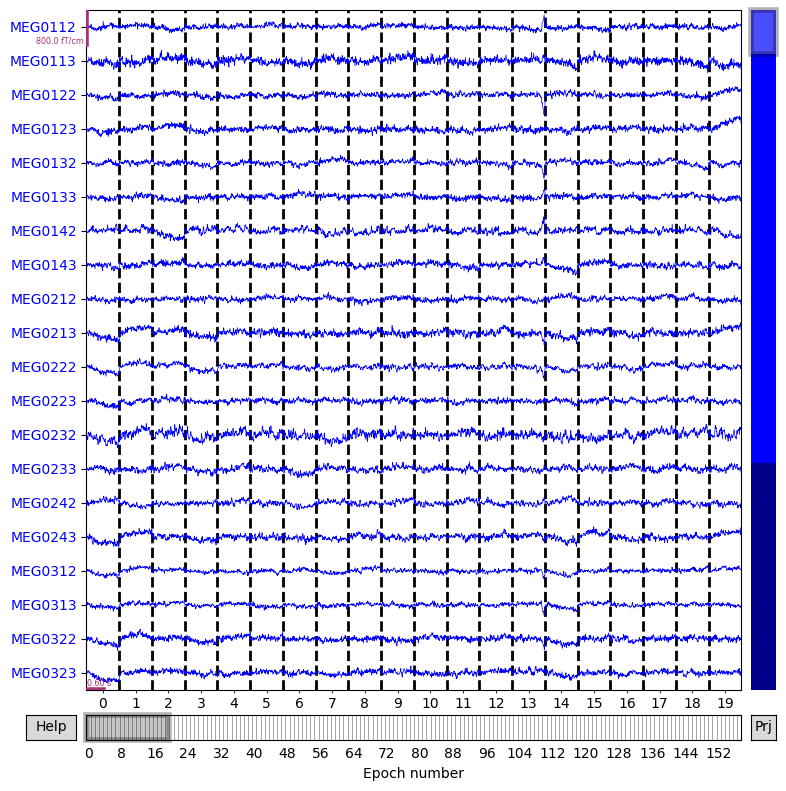

In [ ]:
#Segment the data into epochs
#Epochs can be rejected, if the signal exceeds the range that is expected. Read more here: https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs
# reject = dict(mag=4e-12, grad=4000e-13, eog=250e-6) # T, T/m, V   #You can try it out
reject = None    #Otherwise, all epochs are kept
#Create the epochs around the events. tmin is the time before the event, and tmax the time after the event.

# Locate indices of confidence events (300 and 301)
confidence_indices = np.where(np.isin(epochs.events[:, 2], [300, 301]))[0]

# Slice epochs.events using indices
confidence_events = epochs.events[confidence_indices]

# Define event_id for confidence triggers
confidence_event_id = {"low_confidence": 300, "high_confidence": 301}

# Create epochs for the confidence triggers
epochs = mne.Epochs(
    raw, 
    confidence_events, 
    event_id=confidence_event_id, 
    preload=True,
    on_missing='warn',   #only report on missing events in data, but continue script
    tmin=-0.200,
    tmax=1.000,
    baseline=(None, 0),
    reject=reject,
    proj=False
)

# Plot the confidence epochs
epochs.plot();


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


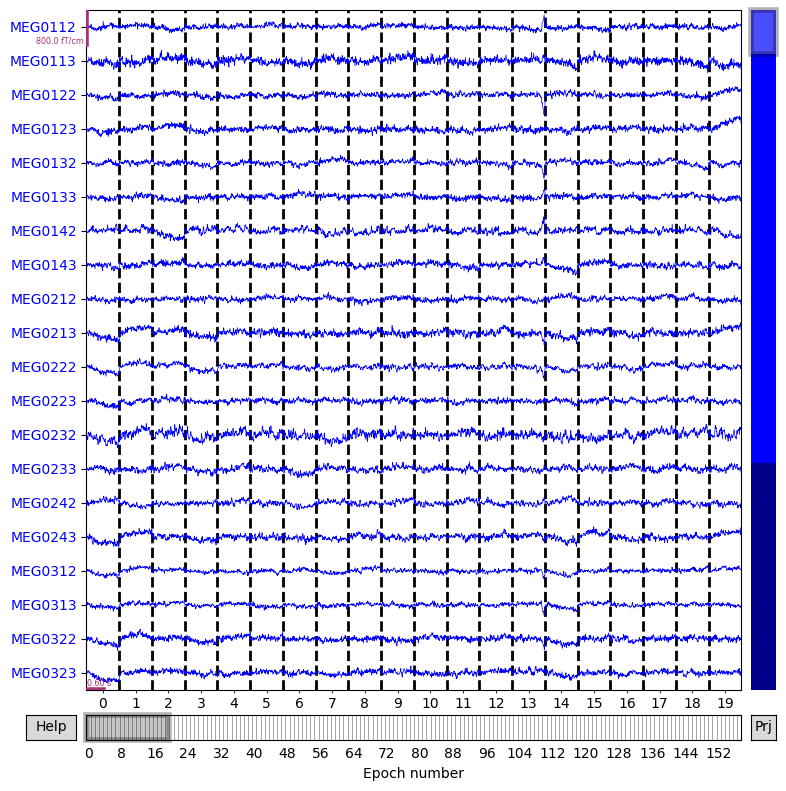

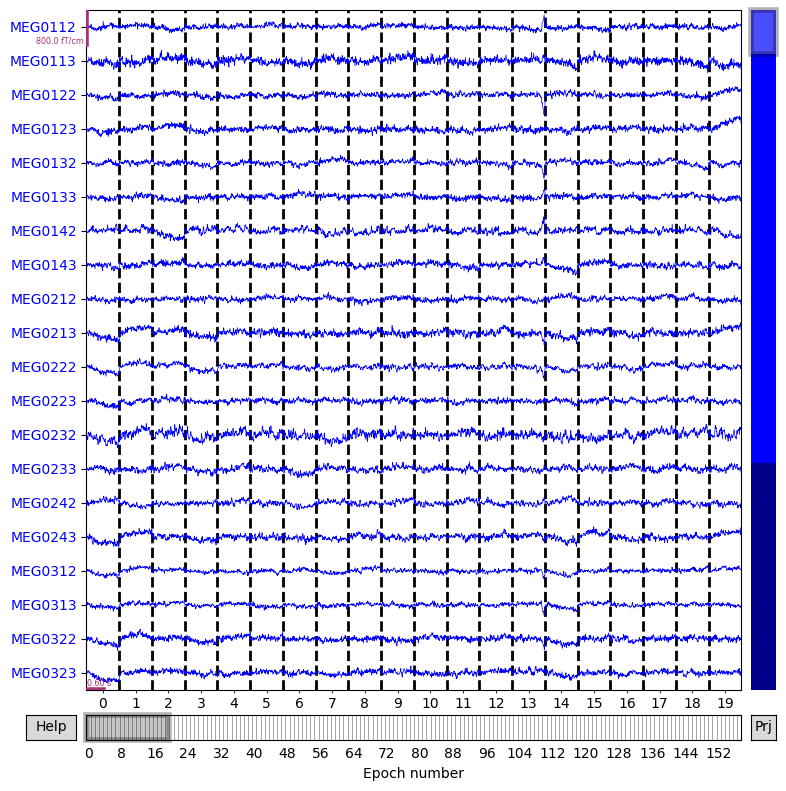

In [ ]:
#Pick only MEG channels
epochs.pick_types(meg=True, eog=False, ias=False, emg=False, misc=False, stim=False, syst=False)

#show the epochs
epochs.plot()

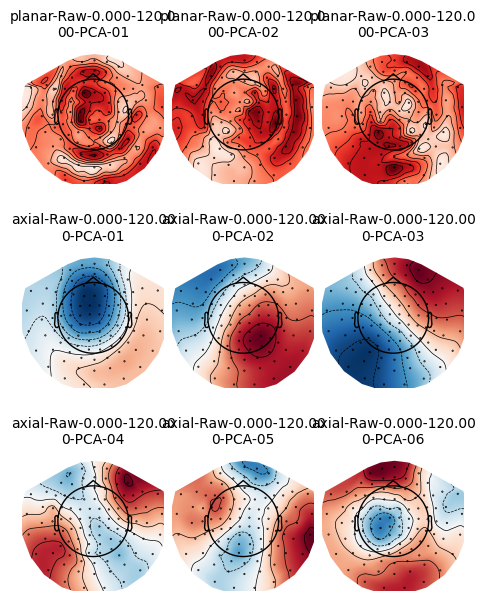

Created an SSP operator (subspace dimension = 9)
9 projection items activated
SSP projectors applied...


<Epochs | 158 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~448.1 MB, data loaded,
 'low_confidence': 79
 'high_confidence': 79>

In [ ]:
# %% SSP PROJECTIONS
#SSP projectors are calculated to remove environmental noise from the MEG signal. Read more here: https://mne.tools/stable/auto_tutorials/preprocessing/45_projectors_background.html#tut-projectors-background
#Visualize the projectors that contain signal from outside the head
mne.viz.plot_projs_topomap(epochs.info["projs"], epochs.info)

#apply the projections
epochs.apply_proj()

In [ ]:
# %% ARRAY OF INTEREST FOR CLASSIFICATIION

X = epochs.get_data()
y = epochs.events[:, 2]   #Choose the last column

times = epochs[0].times # get time points for later

In [ ]:
#%% SIMPLE CLASSIFICATION
#Set functions for classification
import numpy as np

def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

def simple_classication(X, y, triggers, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    # equalize_number_of_indices()
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        #print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


In [ ]:
#%% RUN FUNCTION
#More information about L2 penalty in logistic regression to prevent overfitting: https://www.geeksforgeeks.org/what-is-l2-penalty-in-logistic-regression/
#Classify based on two different trigger events
sensor_conf = simple_classication(X,
                                  y, triggers=[300, 301],
                                  penalty='l2', C=1e-3)

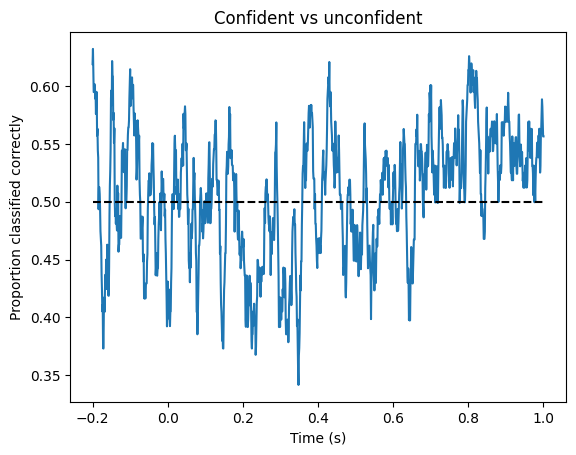

In [ ]:
#%% PLOT
plot_classfication(times, sensor_conf,
                   title='Confident vs unconfident')

# Source space

In [ ]:
# %% SOURCE RECONSTRUCTION 

bem_path = "/work/freesurfer/" + "0145/bem"    
subjects_dir = "/work/freesurfer/"    #path to all subjects
fwd_name = "0145-sessA-src-fwd.fif"  
subject = '0145'

# read forward solution
fwd = mne.read_forward_solution(join(bem_path, fwd_name))
src = fwd["src"]  # where are the sources
trans = fwd["mri_head_t"]  # what's the transformation between mri and head space
info = epochs.info  # where are the sensors?
bem_sol = fwd["sol"]  # how do electric fields spread from the sources inside the head?


Reading forward solution from /work/freesurfer/0145/bem/0145-sessA-src-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 31758
[done]
Computing rank from covariance with rank=None
    Using tolerance 3.7e-15 (2.2e-16 eps * 102 dim * 0.16  max singular value)
    Estimated rank (mag): 96
    MAG: rank 96 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.1e-13 (2.2e-16 eps * 204 dim * 2.4  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 data channels with 0 projectors


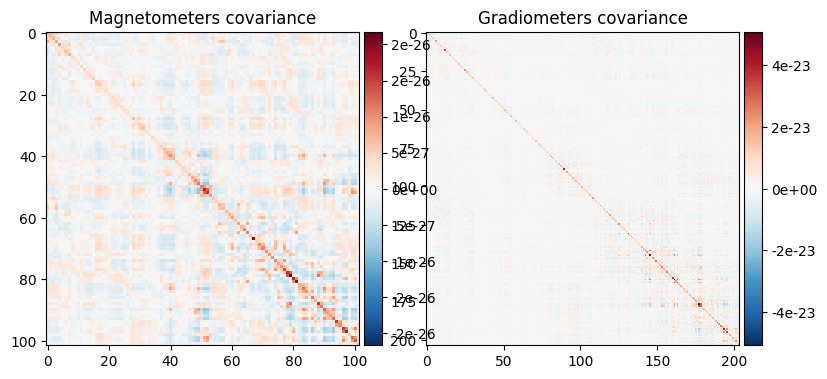

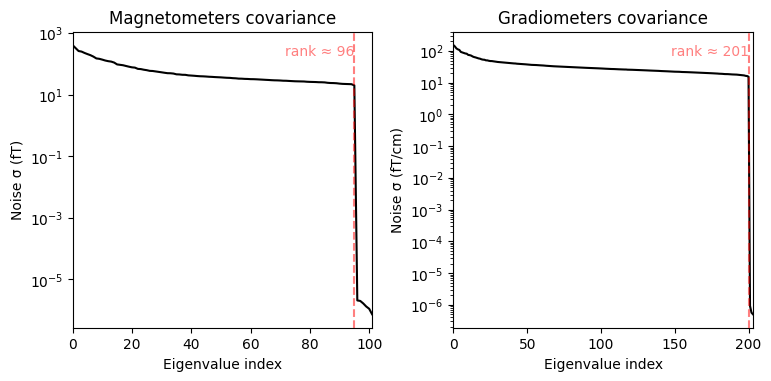

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [ ]:
# %% estimate covariance in the baseline to whiten magnetometers and gradiometers, 
# i.e. normalizing magnetometers, gradiometers and electrode readings to make them comparable
noise_cov = mne.compute_covariance(epochs, tmax=0.000)
noise_cov.plot(epochs.info)  # not full range due to projectors projected out

In [ ]:
# %% operator that specifies how noise cov should be applied to the fwd
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7789/8196 = 10.015505
    scale = 2.94914e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 306 dim * 2.4  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and 

In [ ]:
stcs = mne.minimum_norm.apply_inverse_epochs(
    epochs, inverse_operator, lambda2=1, method="MNE", pick_ori="normal"
)

# Mean across epochs - why do we have negative values now as well?
mean_stc = sum(stcs) / len(stcs)
# mean_stc.plot(subjects_dir=subjects_dir, hemi='both', initial_time=0.170)

#arrange the output as a numpy array, which is easier for a classification
stcs_name = "/work/SabrinaSchrollZakiHansen#5217/ACN_F24/ACN_Portfolio_3/in"
stcs_array = np.array([stc for stc in stcs])
np.save(stcs_name, stcs_array)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 158
Processing epoch : 2 / 158
Processing epoch : 3 / 158
Processing epoch : 4 / 158
Processing epoch : 5 / 158
Processing epoch : 6 / 158
Processing epoch : 7 / 158
Processing epoch : 8 / 158
Processing epoch : 9 / 158
Processing epoch : 10 / 158
Processing epoch : 11 / 158
Processing epoch : 12 / 158
Processing epoch : 13 / 158
Processing epoch : 14 / 158
Processing epoch : 15 / 158
Processing epoch : 16 / 158
Processing epoch : 17 / 158
Processing epoch : 18 / 158
Processing epoch : 19 / 158
Processing epoch : 20 / 158
Processing epoch : 21 / 158
Processing epoch : 22 / 158
P

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 158
Processing epoch : 2 / 158
Processing epoch : 3 / 158
Processing epoch : 4 / 158
Processing epoch : 5 / 158
Processing epoch : 6 / 158
Processing epoch : 7 / 158
Processing epoch : 8 / 158
Processing epoch : 9 / 158
Processing epoch : 10 / 158
Processing epoch : 11 / 158
Processing epoch : 12 / 158
Processing epoch : 13 / 158
Processing epoch : 14 / 158
Processing epoch : 15 / 158
Processing epoch : 16 / 158
Processing epoch : 17 / 158
Processing epoch : 18 / 158
Processing epoch : 19 / 158
Processing epoch : 20 / 158
Processing epoch : 21 / 158
Processing epoch : 22 / 158
P

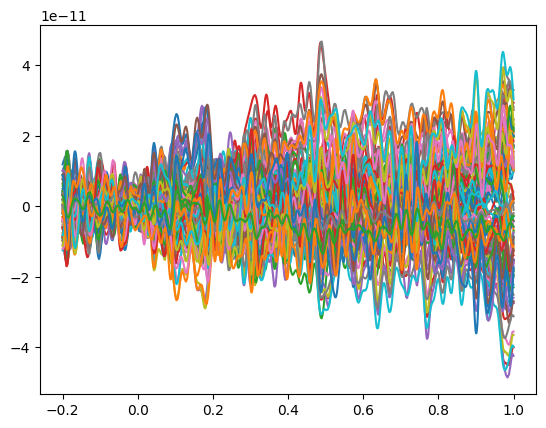

In [ ]:
# %% reconstructing single labels

def reconstruct_label(label_name):
    label = mne.read_label(join(bem_path, "..", "label", label_name))

    stcs = mne.minimum_norm.apply_inverse_epochs(
        epochs, inverse_operator, lambda2=1, method="MNE", pick_ori="normal", label=label
    )

    mean_stc = sum(stcs) / len(stcs)  # over trials, not vertices
    return mean_stc


ltc = reconstruct_label("lh.BA44_exvivo.label")
## check the label path for more labels

plt.figure()
plt.plot(ltc.times, ltc.data.T)
plt.show()

Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
combining channels using RMS (grad channels)
combining channels using RMS (mag channels)


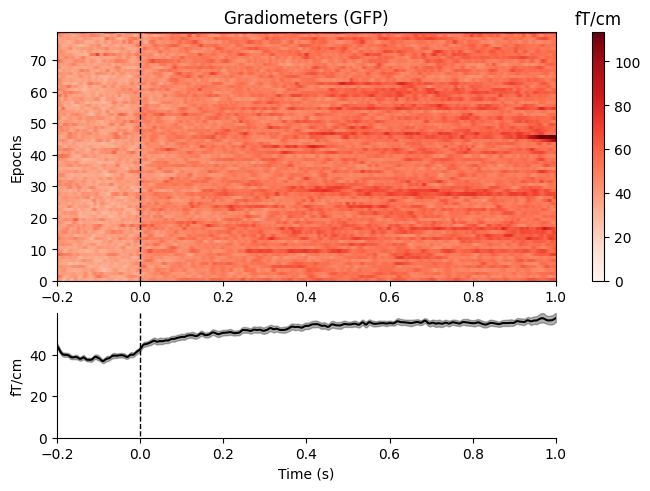

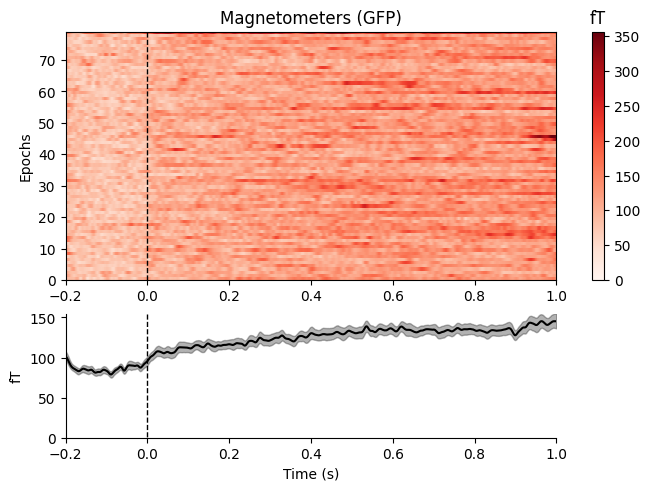

Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
combining channels using RMS (grad channels)
combining channels using RMS (mag channels)


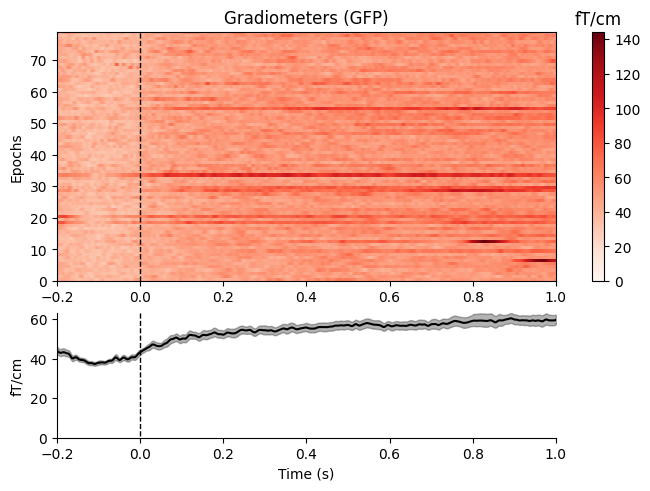

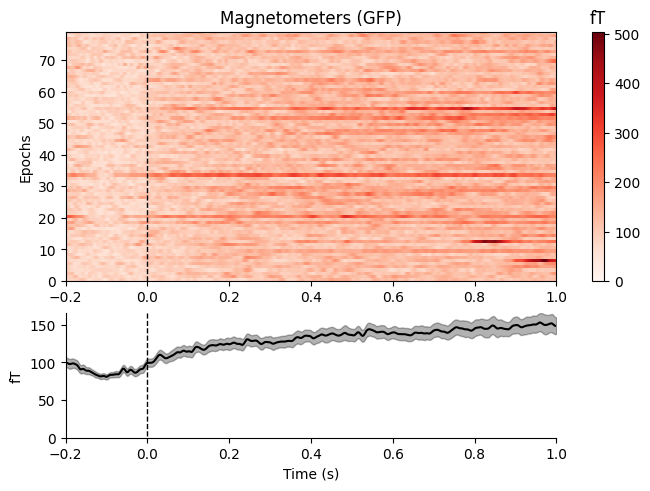

In [ ]:
epochs['low_confidence'].plot_image();
epochs['high_confidence'].plot_image();

In [ ]:
labels_vol = [
    "ctx-lh-medialorbitofrontal",  # Left Medial Orbitofrontal
    "ctx-rh-medialorbitofrontal",  # Right Medial Orbitofrontal
    "ctx-lh-superiorfrontal",      # Left Superior Frontal
    "ctx-rh-superiorfrontal",      # Right Superior Frontal
    "ctx-lh-rostralanteriorcingulate",  # Left Rostral Anterior Cingulate
    "ctx-rh-rostralanteriorcingulate"   # Right Rostral Anterior Cingulate
]

mri_path = "/work/freesurfer/" + "0145/mri"
fname_aseg = mri_path + "/aseg.mgz"
bem_path = "/work/freesurfer/" + "0145/bem"    


vol_src = mne.setup_volume_source_space(
    subject=subject,
    mri=fname_aseg,
    pos=10.0,
    bem=bem_path + '/0145-bem-sol.fif',
    volume_label=labels_vol,
    subjects_dir=subjects_dir,
    add_interpolator=False,  # just for speed, usually this should be True
    verbose=True,
)

# Generate the mixed source space
src += vol_src
print(
    f"The source space contains {len(src)} spaces and "
    f"{sum(s['nuse'] for s in src)} vertices"
)

BEM              : /work/freesurfer/0145/bem/0145-bem-sol.fif
grid                  : 10.0 mm
mindist               : 5.0 mm
MRI volume            : /work/freesurfer/0145/mri/aseg.mgz

Reading /work/freesurfer/0145/mri/aseg.mgz...



Loaded inner skull from /work/freesurfer/0145/bem/0145-bem-sol.fif (2562 nodes)
Surface CM = (   1.3  -16.2   34.8) mm
Surface fits inside a sphere with radius   96.5 mm
Surface extent:
    x =  -70.1 ...   72.5 mm
    y = -103.1 ...   77.8 mm
    z =  -47.1 ...  108.3 mm
Grid extent:
    x =  -80.0 ...   80.0 mm
    y = -110.0 ...   80.0 mm
    z =  -50.0 ...  110.0 mm
5780 sources before omitting any.
3596 sources after omitting infeasible sources not within 0.0 - 96.5 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 3596 points...
    Found  600/3596 points inside  an interior sphere of radius   52.4 mm
    Found    0/3596 points outside an exterior sphere of radius   96.5 mm
    Found 1635/2996 points outside using surface Qhull
    Found   82/1361 points outside using solid angles
    Total 1879/3596 points inside the surface
Interior check completed in 

/tmp/ipykernel_1093/3094440542.py:15: RuntimeWarning: Found no usable vertices in volume label 'ctx-lh-medialorbitofrontal' (id=1014) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1093/3094440542.py:15: RuntimeWarning: Found no usable vertices in volume label 'ctx-rh-medialorbitofrontal' (id=2014) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1093/3094440542.py:15: RuntimeWarning: Found no usable vertices in volume label 'ctx-lh-superiorfrontal' (id=1028) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1093/3094440542.py:15: RuntimeWarning: Found no usable vertices in volume label 'ctx-rh-superiorfrontal' (id=2028) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykernel_1093/3094440542.py:15: RuntimeWarning: Found no usable vertices in volume label 'ctx-lh-rostralanteriorcingulate' (id=1026) using a 10.0 mm grid
  vol_src = mne.setup_volume_source_space(
/tmp/ipykerne

In [ ]:
print(vol_src)

<SourceSpaces: [<volume (ctx-lh-medialorbitofrontal), n_used=0>, <volume (ctx-rh-medialorbitofrontal), n_used=0>, <volume (ctx-lh-superiorfrontal), n_used=0>, <volume (ctx-rh-superiorfrontal), n_used=0>, <volume (ctx-lh-rostralanteriorcingulate), n_used=0>, <volume (ctx-rh-rostralanteriorcingulate), n_used=0>] MRI (surface RAS) coords, subject '0145', ~7.2 MB>


In [ ]:
## forward model as a volume

path_trans = join(bem_path, '0145-trans.fif')
output_name = bem_path + '\0145-sessA-src-fwd_vol.fif'

info = mne.io.read_info(fname)
trans = path_trans   
bem = join(bem_path, '0145-bem-sol.fif')            

fwd_vol = mne.make_forward_solution(info, trans, vol_src, bem, meg=True, eeg=False, verbose=True)

    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
Source space          : <SourceSpaces: [<volume (ctx-lh-medialorbitofrontal), n_used=0>, <volume (ctx-rh-medialorbitofrontal), n_used=0>, <volume (ctx-lh-superiorfrontal), n_used=0>, <volume (ctx-rh-superiorfrontal), n_used=0>, <volume (ctx-lh-rostralanteriorcingulate), n_used=0>, <volume (ctx-rh-rostralanteriorcingulate), n_used=0>] MRI (surface RAS) coords, subject '0145', ~7.2 MB>
MRI -> head transform : /work/freesurfer/0145/bem/0145-trans.fif
Measuremen

RuntimeError: No sources are active in these source spaces. "do_all" option should be used.

In [ ]:
#inverse model
inverse_operator_vol = mne.minimum_norm.make_inverse_operator(info, fwd_vol, noise_cov)

Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking


Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 152/161 = 10.719502
    scale = 1.39904e-08 exp = 0.8
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 1.6e-13 (2.2e-16 eps * 306 dim * 2.4  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 9.19341
    scaling factor to adjust the trace = 1.86845e+17 (nchan = 306 nzero = 9)


In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

#inverse_operator = read_inverse_operator(fname_inv)
src_vol = inverse_operator_vol['src']

# Compute inverse solution
stc_vol = mne.minimum_norm.apply_inverse(epochs, inverse_operator_vol, lambda2, method)
#stc.crop(0.0, 0.2)


TypeError: evoked must be an instance of Evoked, got <class 'mne.epochs.Epochs'> instead.

In [ ]:
#Finally, we can make a plot on ucloud!

# Export result as a 4D nifti object
img = stc_vol.as_volume(src_vol, mri_resolution=False)  # set True for full MRI resolution

# Save it as a nifti file
# nib.save(img, 'mne_%s_inverse.nii.gz' % method)

t1_fname = join(mri_path, 'T1.mgz')

plot_stat_map(index_img(img, 50), str(t1_fname), threshold=1.,
              title='%s (t=%.1f s.)' % (method, stc_vol.times[50]))

plt.show()

NameError: name 'stc_vol' is not defined